# 5. Guild-based Annotation

> **Goal:** Infer fungal functional lifestyles (trophic modes) from ITS ASVs and test whether lifestyle composition differs across metadata groups.

---

**Overview**

This section assigns functional traits to the detected fungal ASVs using the FungalTraits database.  
Because FungalTraits provides trait information at the species/genus level, the workflow first links ASVs to taxonomy, then transfers traits to ASVs and summarizes them at the sample level as relative abundances.

The workflow is organized into three key steps:

1. **Preparation of FungalTraits input files**  
   QIIME2 artifacts are exported and converted to tables, taxonomy strings are parsed to extract genus/species, and only species-level assignments are retained.

2. **Guild-based annotation and aggregation per sample**  
   ASVs are mapped to FungalTraits entries, then abundances are summed per lifestyle and converted to relative abundance per sample.

3. **Visualization and statistical testing**  
    Lifestyle composition is visualized across metadata groups, and group differences are tested using Kruskal–Wallis** with **FDR correction.

    The following metadata categories were analysed:

    - **IBD:** Comparing fungal lifestyle composition between officially- and self-diagnosed IBD categories and the group without IBD.
    - **Gluten status:** Comparing fungal lifestyle composition between CD, gluten-allergic and gluten-free categories and the group without CD.
    - **Diet:** Comparing fungal lifestyle composition between red meat-free, fully vegetarian, only-eating-seafood vegetarian and vegan categories and the omnivore group.
    - **Gender:** Comparing fungal lifestyle composition between female and other categories against males.
    - **BMI:** Comparing fungal lifestyle composition between underweight, overweight, obese and severe obese categories and the healthy BMI group.
    - **Continent:** Comparing fungal lifestyle composition between America, Oceania and Europe.
    - **Urbanization:** Comparing fungal lifestyle composition between different urbanization categories.
 
 
---

**Table of Contents**

- [5.1 Import packages](#5.1-Import-packages)
- [5.2 Data directory](#5.2-Data-directory)
- [5.3 Export QIIME2 artifacts to TSV](#5.3-Export-QIIME2-artifacts-to-TSV)
- [5.4 Build the FungalTraits input table](#5.4-Build-the-FungalTraits-input-table)
- [5.5 Extract genus & species from taxonomy](#5.5-Extract-genus-&-species-from-taxonomy)
- [5.6 Create mapping tables for FungalTraits](#5.6-Create-mapping-tables-for-FungalTraits)
- [5.7 Guild-based annotation with FungalTraits](#5.7-Guild-based-annotation-with-FungalTraits)
    - [5.7.1 IBD](#5.7.1-IBD)
    - [5.7.2 Gluten status](#5.7.2-Gluten-status)
    - [5.7.3 Diet](#5.7.3-Diet)
    - [5.7.4 Gender](#5.7.4-Gender)
    - [5.7.5 BMI](#5.7.5-BMI)
    - [5.7.6 Continent](#5.7.6-Continent)
    - [5.7.7 Urbanization](#5.7.7-Urbanization)
    - [5.7.8 Statistical testing](#5.7.8-Statistical-testing)

## 5.1 Import packages

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import qiime2 as q2
from qiime2 import Visualization
from scipy.stats import shapiro, kruskal, f_oneway

## 5.2 Data directory

In [2]:
# Location
data_dir = "Project_data/GuildBased_Annotation"
! mkdir -p "$data_dir"

In [3]:
# Paths to project inputs
input_table    = "Project_data/Taxonomy/table_filtered.qza"
input_taxonomy = "Project_data/Taxonomy/taxonomy_pretrained.qza"
input_metadata = "Project_data/Metadata/updated_fungut_metadata.tsv"

In [4]:
%%bash

# Download FungalTraits table
wget -O Project_data/GuildBased_Annotation/FungalTraits_v1.2.csv \
"https://polybox.ethz.ch/index.php/s/aGw4f6TwgACxaJs/download"

--2025-12-19 16:40:59--  https://polybox.ethz.ch/index.php/s/aGw4f6TwgACxaJs/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2112369 (2.0M) [text/csv]
Saving to: ‘Project_data/GuildBased_Annotation/FungalTraits_v1.2.csv’

     0K .......... .......... .......... .......... ..........  2% 56.1M 0s
    50K .......... .......... .......... .......... ..........  4%  127M 0s
   100K .......... .......... .......... .......... ..........  7%  278M 0s
   150K .......... .......... .......... .......... ..........  9%  137M 0s
   200K .......... .......... .......... .......... .......... 12%  297M 0s
   250K .......... .......... .......... .......... .......... 14%  692M 0s
   300K .......... .......... .......... .......... .......... 16%  103M 0s
   350K .......... .......... .......... .......... .......... 19%  589M 0s
   400K ..

## 5.3 Export QIIME2 artifacts to TSV

In [5]:
# Export taxonomy file
! qiime tools export \
    --input-path "$input_taxonomy" \
    --output-path "$data_dir"

# Export feature table (BIOM)
! qiime tools export \
    --input-path "$input_table" \
    --output-path "$data_dir"

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported Project_data/Taxonomy/taxonomy_pretrained.qza as TSVTaxonomyDirectoryFormat to directory Project_data/GuildBased_Annotation
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Exported Project_data/Taxonomy/table_filtered.qza as BIOMV210DirFmt to directory Project_data/GuildBased_Annotation


In [6]:
# Convert BIOM -> TSV
biom_path = f"{data_dir}/feature-table.biom"
tsv_path = f"{data_dir}/feature-table.tsv"

! biom convert \
    -i "$biom_path" \
    -o "$tsv_path" \
    --to-tsv

## 5.4 Build the FungalTraits input table

In [7]:
feature_tsv = f"{data_dir}/feature-table.tsv"

# Load feature table
feature_df = pd.read_csv(
    feature_tsv,
    sep="\t",
    skiprows=[0],      
    index_col=0     
)

feature_df.index.name = "feature_id"
counts_df = feature_df.reset_index() 

print("Feature table shape:", feature_df.shape)
feature_df.head()

Feature table shape: (895, 150)


,ERR5327198,ERR5327199,ERR5327266,ERR5327282,ERR5327284,ERR5327285,ERR5327287,ERR5327288,ERR5327289,ERR5327300,...,ERR5327586,ERR5327587,ERR5327591,ERR5327592,ERR5327596,ERR5327599,ERR5327604,ERR5327605,ERR5327615,ERR5327620
feature_id,,,,,,,,,,,,,,,,,,,,,
b4b4cf0cd970d24a715d6d4ddb2173d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d7740a632d92c0dd6324c4131c5d8d34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
edda090236c8af5510b539c4bc7cd634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a112f028910db87dfd35a3a916544d74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
769fdf5d96caec552665c89f6952d08a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
tax_tsv     = f"{data_dir}/taxonomy.tsv"

# Load taxonomy table
tax_df = pd.read_csv(
    tax_tsv,
    sep="\t",
    comment="#"
)
tax_df = tax_df.rename(columns={
    "Feature ID": "feature_id",
    "Taxon": "taxonomy"
})

# Standardise column names
tax_df = tax_df.rename(columns={
    "Feature ID": "feature_id",
    "Taxon": "taxonomy"
})

print("Taxonomy table shape:", tax_df.shape)
tax_df.head()

Taxonomy table shape: (993, 3)


,feature_id,taxonomy,Confidence
0,f1e00c6f31a5546a15c206010ff3583c,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.737076
1,1ada978c8f3ff08af2668393869257ac,Unassigned,0.369232
2,d43c87d3898407682adec71ba5b27fa4,k__Fungi;p__Ascomycota;c__Eurotiomycetes;o__Eu...,0.793387
3,f931ac9a7305cdd99a02c25a624e5bb8,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.950055
4,21c0d99a18a5bd7179fdac2b3f37ece4,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...,0.999989


In [9]:
feature_ids = set(feature_df.index)
tax_ids     = set(tax_df["feature_id"])

shared_ids = feature_ids & tax_ids
print("Number of IDs in feature table:", len(feature_ids))
print("Number of IDs in taxonomy   :", len(tax_ids))
print("Number of shared IDs        :", len(shared_ids))

Number of IDs in feature table: 895
Number of IDs in taxonomy   : 993
Number of shared IDs        : 895


In [10]:
# Merge counts + taxonomy into one table
fungaltrait_input = counts_df.merge(
    tax_df[["feature_id", "taxonomy"]],
    on="feature_id",
    how="left"
)

# Drop features without taxonomy
fungaltrait_input = fungaltrait_input.dropna(subset=["taxonomy"])

# rename feature_id 
fungaltrait_input = fungaltrait_input.rename(columns={"feature_id": "ASV_ID"})

print("FungalTrait input shape:", fungaltrait_input.shape)
fungaltrait_input.head()

FungalTrait input shape: (895, 152)


,ASV_ID,ERR5327198,ERR5327199,ERR5327266,ERR5327282,ERR5327284,ERR5327285,ERR5327287,ERR5327288,ERR5327289,...,ERR5327587,ERR5327591,ERR5327592,ERR5327596,ERR5327599,ERR5327604,ERR5327605,ERR5327615,ERR5327620,taxonomy
0,b4b4cf0cd970d24a715d6d4ddb2173d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Fungi;p__Ascomycota;c__Ascomycota_cls_Incer...
1,d7740a632d92c0dd6324c4131c5d8d34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...
2,edda090236c8af5510b539c4bc7cd634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...
3,a112f028910db87dfd35a3a916544d74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Fungi;p__Basidiomycota;c__Tremellomycetes;o...
4,769fdf5d96caec552665c89f6952d08a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...


In [11]:
# Save table
fungaltrait_input_path = f"{data_dir}/fungaltrait_input.txt"
fungaltrait_input.to_csv(fungaltrait_input_path, sep="\t", index=False)

print("Saved FungalTrait input to:", fungaltrait_input_path)

Saved FungalTrait input to: Project_data/GuildBased_Annotation/fungaltrait_input.txt


## 5.5 Extract genus & species from taxonomy

In [12]:
def extract_genus_species(tax_str):
    if pd.isna(tax_str):
        return pd.Series({"genus": np.nan, "species": np.nan})

    parts = [p.strip() for p in tax_str.split(";")]

    # find g__ and s__ entries
    genus = next((p[3:] for p in parts if p.startswith("g__")), np.nan)
    species = next((p[3:] for p in parts if p.startswith("s__")), np.nan)

    # FungalTraits uses 'Genus species' with a space, not underscores
    if isinstance(species, str) and species not in ("", "unassigned", "Unassigned", "s__"):
        species_clean = species.replace("_", " ")
    else:
        species_clean = np.nan

    return pd.Series({"genus": genus, "species": species_clean})

# Apply to the taxonomy column of your merged table
tax_parsed = fungaltrait_input["taxonomy"].apply(extract_genus_species)

# Attach genus & species columns
fungaltrait_input = pd.concat([fungaltrait_input, tax_parsed], axis=1)

print(fungaltrait_input[["ASV_ID", "taxonomy", "genus", "species"]].head())

                             ASV_ID  \
0  b4b4cf0cd970d24a715d6d4ddb2173d5   
1  d7740a632d92c0dd6324c4131c5d8d34   
2  edda090236c8af5510b539c4bc7cd634   
3  a112f028910db87dfd35a3a916544d74   
4  769fdf5d96caec552665c89f6952d08a   

                                            taxonomy  \
0  k__Fungi;p__Ascomycota;c__Ascomycota_cls_Incer...   
1  k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...   
2  k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...   
3  k__Fungi;p__Basidiomycota;c__Tremellomycetes;o...   
4  k__Fungi;p__Ascomycota;c__Saccharomycetes;o__S...   

                           genus                       species  
0  Ascomycota_gen_Incertae_sedis                 Ascomycota sp  
1                        Dekkera          Dekkera bruxellensis  
2                     Geotrichum                           NaN  
3            Cutaneotrichosporon  Cutaneotrichosporon mucoides  
4                     Clavispora         Clavispora lusitaniae  


In [13]:
# only keep ASVs with species-level IDs
fungaltrait_input_species = fungaltrait_input.dropna(subset=["species"])

print("Rows before species filter:", fungaltrait_input.shape[0])
print("Rows after species filter :", fungaltrait_input_species.shape[0])

Rows before species filter: 895
Rows after species filter : 657


## 5.6 Create mapping tables for FungalTraits

In [14]:
# ASV ↔ species mapping
asv_species_map = fungaltrait_input_species[["ASV_ID", "genus", "species"]].drop_duplicates()

asv_species_path = f"{data_dir}/fungaltrait_asv_species.tsv"
asv_species_map.to_csv(asv_species_path, sep="\t", index=False)

print("Saved ASV–species map to:", asv_species_path)
asv_species_map.head()

Saved ASV–species map to: Project_data/GuildBased_Annotation/fungaltrait_asv_species.tsv


,ASV_ID,genus,species
0,b4b4cf0cd970d24a715d6d4ddb2173d5,Ascomycota_gen_Incertae_sedis,Ascomycota sp
1,d7740a632d92c0dd6324c4131c5d8d34,Dekkera,Dekkera bruxellensis
3,a112f028910db87dfd35a3a916544d74,Cutaneotrichosporon,Cutaneotrichosporon mucoides
4,769fdf5d96caec552665c89f6952d08a,Clavispora,Clavispora lusitaniae
5,257defee9fc7099017bafaef525d6766,Veronaea,Veronaea compacta


In [15]:
# Count table (ASVs × samples) with IDs
sample_cols = [c for c in fungaltrait_input_species.columns
               if c not in ["taxonomy", "genus", "species"]]

counts_only = fungaltrait_input_species[sample_cols]

counts_path = f"{data_dir}/fungaltrait_counts.tsv"
counts_only.to_csv(counts_path, sep="\t", index=False)

print("Saved counts table to:", counts_path)
counts_only.head()

Saved counts table to: Project_data/GuildBased_Annotation/fungaltrait_counts.tsv


,ASV_ID,ERR5327198,ERR5327199,ERR5327266,ERR5327282,ERR5327284,ERR5327285,ERR5327287,ERR5327288,ERR5327289,...,ERR5327586,ERR5327587,ERR5327591,ERR5327592,ERR5327596,ERR5327599,ERR5327604,ERR5327605,ERR5327615,ERR5327620
0,b4b4cf0cd970d24a715d6d4ddb2173d5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,d7740a632d92c0dd6324c4131c5d8d34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,a112f028910db87dfd35a3a916544d74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,769fdf5d96caec552665c89f6952d08a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,257defee9fc7099017bafaef525d6766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5.7 Guild-based annotation with FungalTraits
This analysis is done in R

In [16]:
%load_ext rpy2.ipython

In [17]:
%%capture --no-display
%%R
# Set CRAN mirror
options(repos = c(CRAN = "https://cloud.r-project.org/"))

# Install packages quietly
install.packages("readr", quiet = TRUE)
install.packages("dplyr", quiet = TRUE)
install.packages("reshape2", quiet = TRUE)
install.packages("ggplot2", quiet = TRUE)
install.packages("tidyr", quiet = TRUE)

In [18]:
%%capture --no-display
%%R
# Load packages silently
suppressWarnings(library(readr))
suppressWarnings(library(dplyr))
suppressWarnings(library(reshape2))
suppressWarnings(library(ggplot2))
suppressWarnings(library(tidyr))

In [19]:
%%R

# ASV ↔ species mapping (ASV_ID, genus, species)
asv_species <- read_tsv("Project_data/GuildBased_Annotation/fungaltrait_asv_species.tsv", show_col_types = FALSE)

# Count table (ASV_ID + sample columns)
asv_counts  <- read_tsv("Project_data/GuildBased_Annotation/fungaltrait_counts.tsv", show_col_types = FALSE)

# Metadata
metadata    <- read_tsv("Project_data/Metadata/updated_fungut_metadata.tsv", show_col_types = FALSE)

head(asv_species)
head(asv_counts)[, 1:5]

# A tibble: 6 × 5
  ASV_ID                           ERR5327198 ERR5327199 ERR5327266 ERR5327282
  <chr>                                 <dbl>      <dbl>      <dbl>      <dbl>
1 b4b4cf0cd970d24a715d6d4ddb2173d5          0          0          0          0
2 d7740a632d92c0dd6324c4131c5d8d34          0          0          0          0
3 a112f028910db87dfd35a3a916544d74          0          0          0          0
4 769fdf5d96caec552665c89f6952d08a          0          0          0          0
5 257defee9fc7099017bafaef525d6766          0          0          0          0
6 88aa4c3fe712998bab755340d1b62629          0          0          0          0


In [20]:
%%R
# Load FungalTrait database

# FungalTraits table downloaded from Google Sheets as CSV
fungaltraits <- read_csv("Project_data/GuildBased_Annotation/FungalTraits_v1.2.csv", show_col_types = FALSE)

# Clean column names a bit: no spaces, consistent case
names(fungaltraits) <- gsub("\\s+", "_", names(fungaltraits))

# Make sure there is a column called "species"
if ("Species" %in% names(fungaltraits) && !"species" %in% names(fungaltraits)) {
  fungaltraits <- fungaltraits |> rename(species = Species)
}

# Same for genus if necessary (GENUS → genus)
if ("GENUS" %in% names(fungaltraits) && !"genus" %in% names(fungaltraits)) {
  fungaltraits <- fungaltraits |> rename(genus = GENUS)
}

# Have a look:
head(fungaltraits)

# A tibble: 6 × 24
  jrk_template Phylum     Class           Order    Family genus COMMENT_on_genus
  <chr>        <chr>      <chr>           <chr>    <chr>  <chr> <chr>           
1 jrk11009     Ascomycota Dothideomycetes Asterin… Aster… Pycn… <NA>            
2 jrk11010     Ascomycota Dothideomycetes Asterin… Neobu… Neob… <NA>            
3 jrk11028     Ascomycota Dothideomycetes Muyocop… Muyoc… Neoc… <NA>            
4 <NA>         Ascomycota Dothideomycetes Pleospo… Didym… Anth… <NA>            
5 <NA>         Ascomycota Dothideomycetes Pleospo… Lindg… Aqui… <NA>            
6 jrk11044     Ascomycota Dothideomycetes Pleospo… Lindg… Neol… <NA>            
# ℹ 17 more variables: primary_lifestyle <chr>, Secondary_lifestyle <chr>,
#   Comment_on_lifestyle_template <chr>,
#   Endophytic_interaction_capability_template <chr>,
#   Plant_pathogenic_capacity_template <chr>, Decay_substrate_template <chr>,
#   Decay_type_template <chr>, Aquatic_habitat_template <chr>,
#   Animal_biotrophic_

In [21]:
%%R
# Attach traits to each ASV (species-level join)

# Join by species name: every ASV gets the traits of its species
asv_with_traits <- asv_species %>%
  left_join(fungaltraits, by = "genus")

# Check: do we see trait columns attached?
head(asv_with_traits[, c("ASV_ID", "genus", "species", "primary_lifestyle")])

# A tibble: 6 × 4
  ASV_ID                           genus               species primary_lifestyle
  <chr>                            <chr>               <chr>   <chr>            
1 b4b4cf0cd970d24a715d6d4ddb2173d5 Ascomycota_gen_Inc… Ascomy… <NA>             
2 d7740a632d92c0dd6324c4131c5d8d34 Dekkera             Dekker… nectar/tap_sapro…
3 a112f028910db87dfd35a3a916544d74 Cutaneotrichosporon Cutane… animal_parasite  
4 769fdf5d96caec552665c89f6952d08a Clavispora          Clavis… litter_saprotroph
5 257defee9fc7099017bafaef525d6766 Veronaea            Verona… plant_pathogen   
6 88aa4c3fe712998bab755340d1b62629 Ascomycota_gen_Inc… Ascomy… <NA>             


In [22]:
%%R
# Merges traits with the ASV abundance counts
asv_trait_counts <- asv_with_traits %>%
  left_join(asv_counts, by = "ASV_ID")

# Check
head(asv_trait_counts[, c("ASV_ID", "genus", "primary_lifestyle", "ERR5327198")])

# A tibble: 6 × 4
  ASV_ID                           genus            primary_lifestyle ERR5327198
  <chr>                            <chr>            <chr>                  <dbl>
1 b4b4cf0cd970d24a715d6d4ddb2173d5 Ascomycota_gen_… <NA>                       0
2 d7740a632d92c0dd6324c4131c5d8d34 Dekkera          nectar/tap_sapro…          0
3 a112f028910db87dfd35a3a916544d74 Cutaneotrichosp… animal_parasite            0
4 769fdf5d96caec552665c89f6952d08a Clavispora       litter_saprotroph          0
5 257defee9fc7099017bafaef525d6766 Veronaea         plant_pathogen             0
6 88aa4c3fe712998bab755340d1b62629 Ascomycota_gen_… <NA>                       0


In [23]:
%%R
# Compute Lifestyle Abundance per Sample

# keep only columns that are numeric abundance values
sample_cols <- names(asv_trait_counts)[sapply(asv_trait_counts, is.numeric)]

head(sample_cols)
length(sample_cols)

# Summarize abundance per lifestyle
trophic_by_sample <- asv_trait_counts %>%
  filter(!is.na(primary_lifestyle)) %>%
  group_by(primary_lifestyle) %>%
  summarise(across(all_of(sample_cols), sum)) %>%
  ungroup()

# Absolute counts per lifestyle per sample
head(trophic_by_sample[, 1:6])

# Convert to relative abundance
trophic_rel <- trophic_by_sample
trophic_rel[sample_cols] <- apply(trophic_rel[sample_cols], 2, function(x) x / sum(x))

# Relative abundance per lifestyle per sample
head(trophic_rel[, 1:6])

# transpose: samples as rows, lifestyles as columns
trophic_rel_t <- t(trophic_rel[sample_cols])
colnames(trophic_rel_t) <- trophic_rel$primary_lifestyle
trophic_rel_t <- as.data.frame(trophic_rel_t)

# add sample IDs as a column
trophic_rel_t$SampleID <- rownames(trophic_rel_t)

# Check
head(trophic_rel_t)


           animal_parasite arthropod-associated dung_saprotroph ectomycorrhizal
ERR5327198     0.001125873                    0               0               0
ERR5327199     0.995886593                    0               0               0
ERR5327266     0.000000000                    0               0               0
ERR5327282     0.547265939                    0               0               0
ERR5327284     0.001715429                    0               0               0
ERR5327285     0.032544379                    0               0               0
           epiphyte litter_saprotroph mycoparasite nectar/tap_saprotroph
ERR5327198        0      0.0000000000            0           0.998874127
ERR5327199        0      0.0000000000            0           0.004113407
ERR5327266        0      0.0000000000            0           1.000000000
ERR5327282        0      0.0000000000            0           0.450239034
ERR5327284        0      0.0006671114            0           0.997236253
ER

In [24]:
%%R
# Attach Sample Metadata
colnames(metadata)
metadata <- metadata %>%
  rename(SampleID = ID)

trophic_final <- trophic_rel_t %>%
  left_join(metadata, by = "SampleID")

# Check
head(trophic_final)

  animal_parasite arthropod-associated dung_saprotroph ectomycorrhizal epiphyte
1     0.001125873                    0               0               0        0
2     0.995886593                    0               0               0        0
3     0.000000000                    0               0               0        0
4     0.547265939                    0               0               0        0
5     0.001715429                    0               0               0        0
6     0.032544379                    0               0               0        0
  litter_saprotroph mycoparasite nectar/tap_saprotroph plant_pathogen
1      0.0000000000            0           0.998874127              0
2      0.0000000000            0           0.004113407              0
3      0.0000000000            0           1.000000000              0
4      0.0000000000            0           0.450239034              0
5      0.0006671114            0           0.997236253              0
6      0.1094674556 

In [25]:
%%R
# Select the lifestyle columns
meta_cols <- colnames(metadata)
lifestyle_cols <- setdiff(colnames(trophic_final),
                          c("SampleID", meta_cols))

lifestyle_cols

trophic_long <- trophic_final %>%
  select(SampleID, all_of(lifestyle_cols)) %>%
  pivot_longer(
    cols      = all_of(lifestyle_cols),
    names_to  = "Lifestyle",
    values_to = "RelAbundance"
  ) %>%
  left_join(metadata, by = "SampleID")

### 5.7.1 IBD

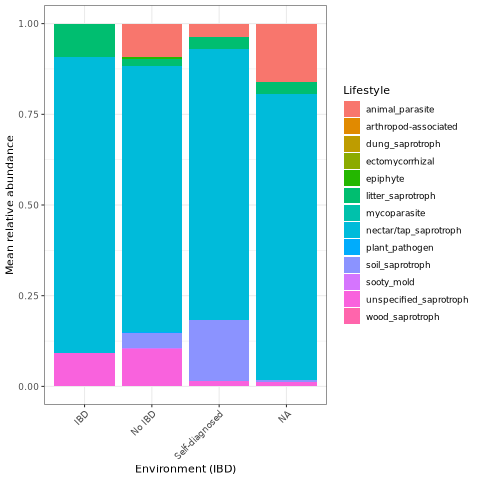

In [26]:
%%R
trophic_group <- trophic_long %>% 
  group_by(ibd_sample, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_ibd <- ggplot(trophic_group,
       aes(x = ibd_sample, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (IBD)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(plot_ibd)

### 5.7.2 Gluten status

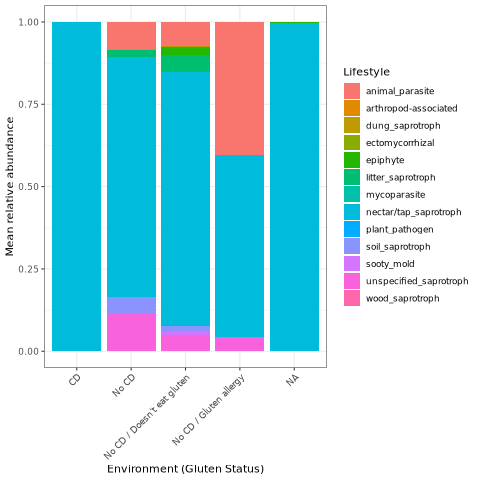

In [27]:
%%R
trophic_group_2 <- trophic_long %>% 
  group_by(gluten_sample, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_gluten <- ggplot(trophic_group_2,
       aes(x = gluten_sample, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (Gluten Status)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

print(plot_gluten)

### 5.7.3 Diet

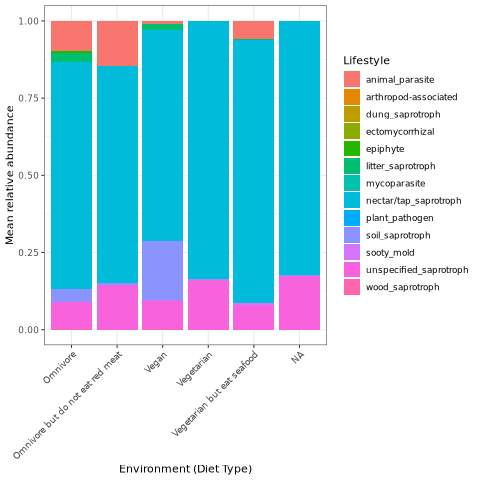

In [28]:
%%R
trophic_group_3 <- trophic_long %>% 
  group_by(diet_type_sample, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_diet <- ggplot(trophic_group_3,
       aes(x = diet_type_sample, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (Diet Type)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
print(plot_diet)

### 5.7.4 Gender

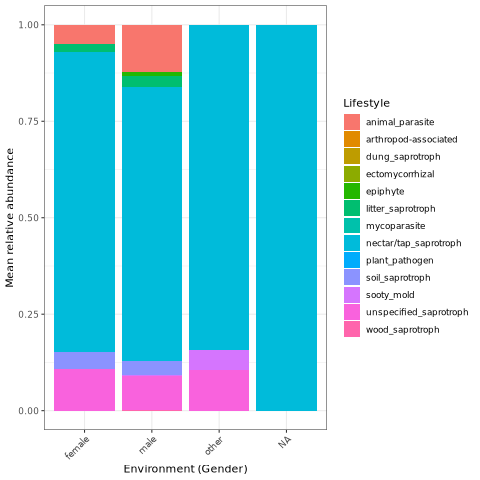

In [29]:
%%R
trophic_group_4 <- trophic_long %>% 
  group_by(sex_sample, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_sex <- ggplot(trophic_group_4,
       aes(x = sex_sample, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (Gender)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
print(plot_sex)

### 5.7.5 BMI

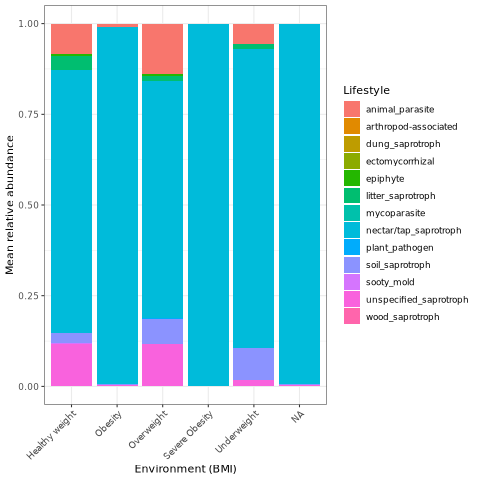

In [30]:
%%R
trophic_group_5 <- trophic_long %>% 
  group_by(bmi_category, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_bmi <- ggplot(trophic_group_5,
       aes(x = bmi_category, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (BMI)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
print(plot_bmi)

### 5.7.6 Continent

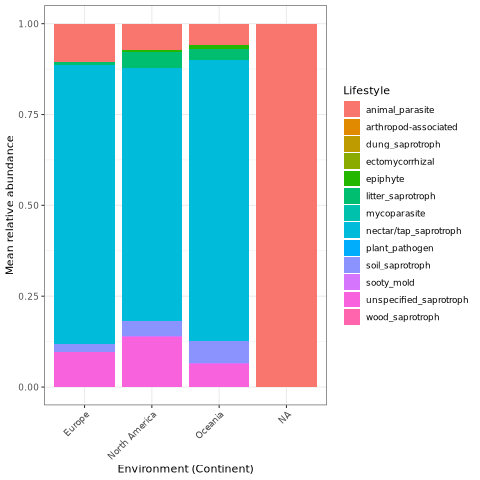

In [31]:
%%R
trophic_group_6 <- trophic_long %>% 
  group_by(continent, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_continent <- ggplot(trophic_group_6,
       aes(x = continent, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (Continent)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
print(plot_continent)

### 5.7.7 Urbanization

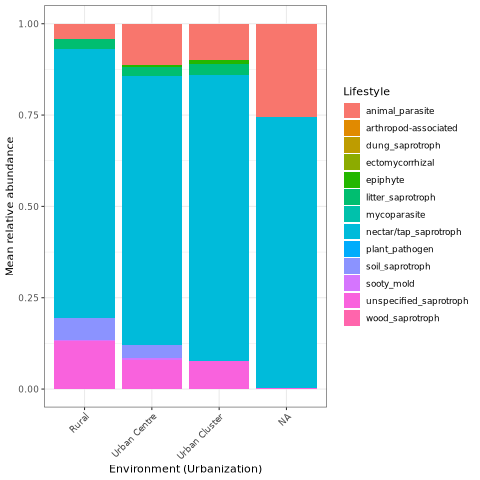

In [32]:
%%R
trophic_group_7 <- trophic_long %>% 
  group_by(urban_category, Lifestyle) %>%           
  summarise(mean_rel = mean(RelAbundance),
            .groups = "drop")

plot_urbanization <- ggplot(trophic_group_7,
       aes(x = urban_category, y = mean_rel, fill = Lifestyle)) +
  geom_col(position = "fill") +              
  ylab("Mean relative abundance") +
  xlab("Environment (Urbanization)") +
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
    
print(plot_urbanization)

### 5.7.8 Statistical testing

In [33]:
%%R
# Metadata variables analysed in Step 7
meta_vars <- c("ibd_sample", "gluten_sample", "diet_type_sample",
               "sex_sample", "bmi_category", "continent", "urban_category")

# all lifestyle columns
lifestyle_cols <- setdiff(colnames(trophic_final),
                          c("SampleID", colnames(metadata)))

# Kruskal–Wallis
run_kw <- function(meta_var) {
  results <- lapply(lifestyle_cols, function(lf) {
    
    # remove samples with missing metadata
    df <- trophic_final %>%
      filter(!is.na(.data[[meta_var]]))
    
    test <- kruskal.test(df[[lf]] ~ df[[meta_var]])
    
    data.frame(
      Lifestyle = lf,
      Metadata  = meta_var,
      p_value   = test$p.value
    )
  })
  
  do.call(rbind, results)
}

kw_results <- lapply(meta_vars, run_kw)
kw_results <- do.call(rbind, kw_results)

# adjust for multiple testing
kw_results$padj <- p.adjust(kw_results$p_value, method = "fdr")

print(kw_results)

                Lifestyle         Metadata      p_value        padj
1         animal_parasite       ibd_sample 1.329288e-01 0.736004559
2    arthropod-associated       ibd_sample 9.512294e-01 0.986461048
3         dung_saprotroph       ibd_sample 9.042004e-01 0.986461048
4         ectomycorrhizal       ibd_sample 9.512294e-01 0.986461048
5                epiphyte       ibd_sample 7.732583e-01 0.986461048
6       litter_saprotroph       ibd_sample 5.763655e-01 0.972632560
7            mycoparasite       ibd_sample 8.588830e-01 0.986461048
8   nectar/tap_saprotroph       ibd_sample 3.686084e-01 0.972632560
9          plant_pathogen       ibd_sample 4.366379e-01 0.972632560
10        soil_saprotroph       ibd_sample 1.699894e-02 0.248632102
11             sooty_mold       ibd_sample 6.940989e-01 0.972632560
12 unspecified_saprotroph       ibd_sample 8.239009e-01 0.986461048
13        wood_saprotroph       ibd_sample 1.861376e-01 0.769932783
14        animal_parasite    gluten_sample 1.635

In [34]:
%%R
# significant results
sig <- subset(kw_results, padj < 0.05)

# only show significant results
print(sig)

    Lifestyle   Metadata      p_value        padj
50 sooty_mold sex_sample 5.076549e-05 0.004619659


In [35]:
%%R
# Further testing pairwise groups in the gender category since it is the only sgnificant result
df <- trophic_final %>%
  select(sooty_mold, sex_sample) %>%
  filter(!is.na(sex_sample))

pairwise.wilcox.test(
  df$sooty_mold,
  df$sex_sample,
  p.adjust.method = "fdr"
)


	Pairwise comparisons using Wilcoxon rank sum test with continuity correction 

data:  df$sooty_mold and df$sex_sample 

      female  male   
male  0.31575 -      
other 4.9e-06 0.00047

P value adjustment method: fdr 


In [36]:
%%R
df %>%
  group_by(sex_sample) %>%
  summarise(
    median_abundance = median(sooty_mold),
    mean_abundance   = mean(sooty_mold)
  )

# A tibble: 3 × 3
  sex_sample median_abundance mean_abundance
  <chr>                 <dbl>          <dbl>
1 female               0           0.0000104
2 male                 0           0.00340  
3 other                0.0503      0.0503   
